In [0]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
import re

random.seed(42)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [0]:
def plot_histogram():
  newsgroups_train = fetch_20newsgroups(subset='train')
  plt.figure
  plt.title('Histogram of Training Documents according to Categories')
  plt.xlabel('Name of the Categories')
  plt.ylabel('Number of Documents')
  plt.hist(newsgroups_train.target, bins=20);
  plt.xticks(np.linspace(0,19,20), newsgroups_train.target_names,rotation=90)

def load_dataset(categories,remove_header_flag):
  if remove_header_flag==True:
    train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, remove=('headers', 'footers'), random_state = None)
    test_dataset = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True,remove=('headers', 'footers'), random_state = None)
  else:
    train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = None)
    test_dataset = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = None)
  return train_dataset,test_dataset

global lemmatizer
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def no_num_tokenizer(document):
    from string import punctuation
    from sklearn.feature_extraction import text

    unlemmatized_words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # unlemmatized_words = [word for word in nltk.word_tokenize(document) if not word.strip('+').strip('-').replace('.','').isdigit()]
    stop_words_skt = text.ENGLISH_STOP_WORDS
    combined_stopwords = set.union(set(stop_words),set(punctuation),set(stop_words_skt))
    words = [lemmatizer.lemmatize(word) for word in unlemmatized_words if word not in combined_stopwords]
    words_pos = lemmatize_sent(words)
    return words_pos

def no_num_tokenizer_no_lemmatization(document):
    from string import punctuation
    from sklearn.feature_extraction import text

    unlemmatized_words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # unlemmatized_words = [word for word in nltk.word_tokenize(document) if not word.strip('+').strip('-').replace('.','').isdigit()]
    stop_words_skt = text.ENGLISH_STOP_WORDS
    combined_stopwords = set.union(set(stop_words),set(punctuation),set(stop_words_skt))
    words = [word for word in unlemmatized_words if word not in combined_stopwords]
    return words



def count_vectorization(train_dataset,test_dataset,minimum_df,lemmatization_flag):
  if lemmatization_flag==True:
    vectorizer = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer, min_df=minimum_df)
  else:
    vectorizer = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer_no_lemmatization, min_df=minimum_df)
  X_train = vectorizer.fit_transform(train_dataset.data).toarray()
  X_test = vectorizer.transform(test_dataset.data).toarray()
  return X_train,X_test

def feature_extraction(X_train,X_test):
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train)
  X_test_tfidf = tfidf_transformer.transform(X_test)
  print("Shape of X_train: ",X_train_tfidf.shape)
  print("Shape of X_test: ",X_test_tfidf.shape)
  return X_train_tfidf,X_test_tfidf

#NMF 
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

def NMF_reduction(X_train_tfidf,X_test_tfidf):
  from sklearn.decomposition import NMF
  model = NMF(n_components=50, init='random', random_state=0)
  W_train = model.fit_transform(X_train_tfidf)
  W_test = model.transform(X_test_tfidf)
  H = model.components_
  NMF_XWH = np.linalg.norm(X_train_tfidf - W_train.dot(H))**2
  print('NMF error: ', NMF_XWH)
  print('Reduced training shape using NMF: ', W_train.shape)
  print('Reduced test shape using NMF: ', W_test.shape)
  return W_train,W_test

#SVD

def LSI_reduction(X_train_tfidf,X_test_tfidf):
  from sklearn.decomposition import TruncatedSVD
  svd = TruncatedSVD(50)
  X_svd_train = svd.fit_transform(X_train_tfidf)
  X_svd_test =svd.transform(X_test_tfidf)
  U = X_svd_train / svd.singular_values_
  Sigma_matrix = np.diag(svd.singular_values_)
  VT = svd.components_
  LSI_XSVD = np.linalg.norm(X_train_tfidf - (U.dot(Sigma_matrix)).dot(VT))**2
  print('LSI error: ', LSI_XSVD)
  print('Reduced training shape using LSI: ', X_svd_train.shape)
  print('Reduced test shape using LSI: ', X_svd_test.shape)
  return X_svd_train,X_svd_test

def dimensionality_reduction(X_train_tfidf,X_test_tfidf,choose_svd_flag):
  if choose_svd_flag==True:
    return NMF_reduction(X_train_tfidf,X_test_tfidf)
  else:
    return LSI_reduction(X_train_tfidf,X_test_tfidf)

#Converts targets to binary classes
def create_binary(train_dataset,test_dataset):
  y_train =train_dataset.target.copy()
  y_train[y_train<=3] = 0
  y_train[y_train>3] = 1

  y_test =test_dataset.target.copy()
  y_test[y_test<=3] = 0
  y_test[y_test>3] = 1
  return y_train,y_test


def evaluation_parameters(y_test,y_pred):
  con_mat = confusion_matrix(y_test,y_pred)
  tn, fp, fn, tp = con_mat.ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*precision*recall/(precision+recall)
  acc = (tp+tn)/(tn+fn+fp+tp)
  print("Confusion Matrix:")
  print(con_mat)
  print("The precision is: ",precision)
  print("The recall is: ",recall)
  print("The f1_score is: ",f1)
  print("The accuracy is: ",acc)

def plot_roc(y_test,y_score):
  fpr,tpr,thresh=roc_curve(y_test,y_score)
  plt.plot(fpr,tpr)
  plt.grid()
  plt.ylim(0,1.1)
  print("The roc score is ",roc_auc_score(y_test,y_score))
  plt.xlabel("Specificity")
  plt.ylabel("Sensitivity")
  plt.title("ROC Curve")



Shape of X_train:  (4732, 13968)
Shape of X_test:  (3150, 13968)
NMF error:  4135.935904947255
Reduced training shape using NMF:  (4732, 50)
Reduced test shape using NMF:  (3150, 50)
LSI error:  4097.068044570017
Reduced training shape using LSI:  (4732, 50)
Reduced test shape using LSI:  (3150, 50)


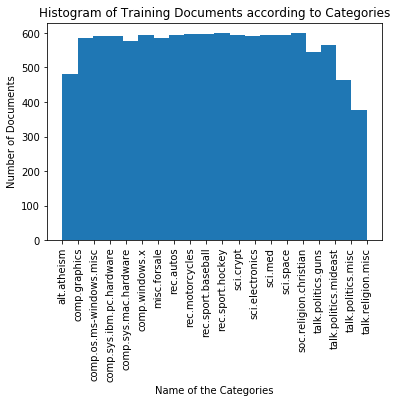

In [0]:
#MAIN CODE
plot_histogram()
random.seed(42)
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset,test_dataset = load_dataset(categories,remove_header_flag = False)
X_train,X_test = count_vectorization(train_dataset,test_dataset,minimum_df=3,lemmatization_flag=True)
X_train_tfidf,X_test_tfidf = feature_extraction(X_train,X_test)
W_train,W_test = NMF_reduction(X_train_tfidf,X_test_tfidf)
X_svd_train,X_svd_test = LSI_reduction(X_train_tfidf,X_test_tfidf)
y_train,y_test = create_binary(train_dataset,test_dataset)



Confusion Matrix:
[[1504   56]
 [  29 1561]]
The precision is:  0.9653679653679653
The recall is:  0.9817610062893082
The f1_score is:  0.9734954786404739
The accuracy is:  0.973015873015873
The roc score is  0.996432430253185


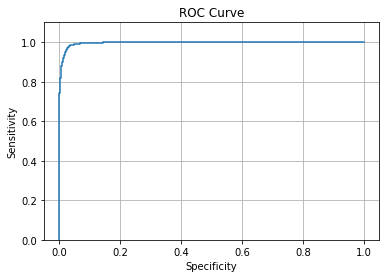

In [0]:
#HARD SVM(gamma = 1000)
from sklearn.svm import SVC
our_svm_model = SVC(kernel = "linear",C=1000,probability=True)
our_svm_model.fit(X_svd_train, y_train)
y_pred = our_svm_model.predict(X_svd_test)
y_score = our_svm_model.decision_function(X_svd_test)
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)

Confusion Matrix:
[[ 597  963]
 [   0 1590]]
The precision is:  0.6227967097532315
The recall is:  1.0
The f1_score is:  0.7675597393193339
The accuracy is:  0.6942857142857143
The roc score is  0.9948153523625222


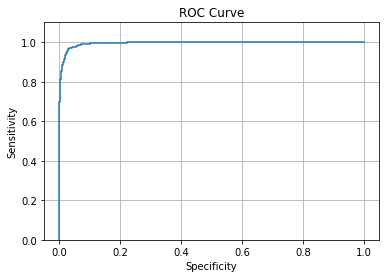

In [0]:
#SOFT SVM(gamma = 0.0001)
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
our_svm_model = LinearSVC(C=0.0001)
our_svm_model.fit(X_svd_train, y_train)
y_pred = our_svm_model.predict(X_svd_test)
y_score = our_svm_model.decision_function(X_svd_test)
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

The best parameter C is:  100.0
Confusion Matrix:
[[1508   52]
 [  27 1563]]
The precision is:  0.9678018575851394
The recall is:  0.9830188679245283
The f1_score is:  0.9753510140405617
The accuracy is:  0.974920634920635
The roc score is  0.9966360264473472


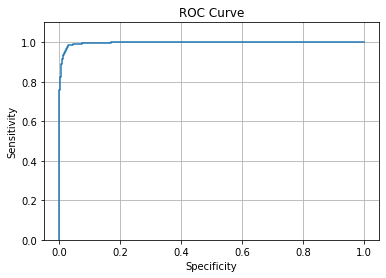

In [0]:
#CROSS VALIDATION FOR SVM
from sklearn.model_selection import GridSearchCV
param_grid_vals = np.power(np.repeat(10.0,7),np.arange(-3,4,1)).tolist()
CVsvm = GridSearchCV(estimator = our_svm_model, param_grid = {'C':param_grid_vals},cv= 5)
CVsvm.fit(X_svd_train, y_train)
best_param = CVsvm.best_params_['C']
print("The best parameter C is: ",best_param)
y_pred = CVsvm.best_estimator_.predict(X_svd_test)
y_score = CVsvm.best_estimator_.decision_function(X_svd_test)
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)


Confusion Matrix:
[[1505   55]
 [  28 1562]]
The precision is:  0.9659863945578231
The recall is:  0.9823899371069182
The f1_score is:  0.9741191144371687
The accuracy is:  0.9736507936507937
The roc score is  0.9965860345105628


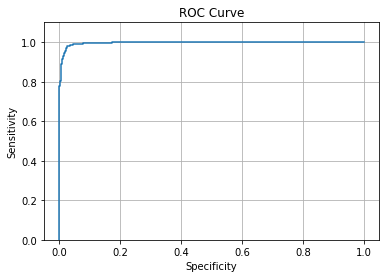

In [0]:
#Logreg without regularization

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 1e13).fit(X_svd_train, y_train)
y_pred = clf.predict(X_svd_test)
y_score = np.squeeze(clf.predict_proba(X_svd_test))[:,1]
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)

The best parameter C is:  1000.0
Confusion Matrix:
[[1507   53]
 [  25 1565]]
The precision is:  0.9672435105067985
The recall is:  0.9842767295597484
The f1_score is:  0.9756857855361596
The accuracy is:  0.9752380952380952
The roc score is  0.9966215126592485


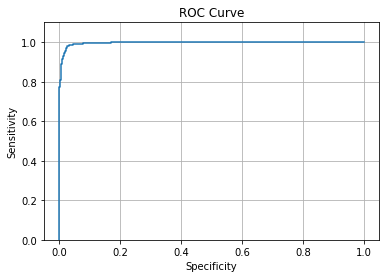

In [0]:
#L2 regularization
CVclf = GridSearchCV(estimator = clf, param_grid = {'C':param_grid_vals,'penalty':['l2'],'solver':['liblinear']},cv= 5)
CVclf.fit(X_svd_train, y_train)
best_param = CVclf.best_params_['C']
print("The best parameter C is: ",best_param)
y_pred = CVclf.best_estimator_.predict(X_svd_test)
y_score = np.squeeze(CVclf.best_estimator_.predict_proba(X_svd_test))[:,1]
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)


The best parameter C is:  1000.0
Confusion Matrix:
[[1505   55]
 [  28 1562]]
The precision is:  0.9659863945578231
The recall is:  0.9823899371069182
The f1_score is:  0.9741191144371687
The accuracy is:  0.9736507936507937
The roc score is  0.996590066118368


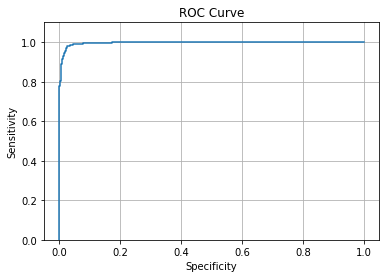

In [0]:
#L1 regularization
CVclf = GridSearchCV(estimator = clf, param_grid = {'C':param_grid_vals,'penalty':['l1'],'solver':['liblinear']},cv= 5)
CVclf.fit(X_svd_train, y_train)
best_param = CVclf.best_params_['C']
print("The best parameter C is: ",best_param)
y_pred = CVclf.best_estimator_.predict(X_svd_test)
y_score = np.squeeze(CVclf.best_estimator_.predict_proba(X_svd_test))[:,1]
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)


Confusion Matrix:
[[1413  147]
 [  98 1492]]
The precision is:  0.9103111653447223
The recall is:  0.9383647798742139
The f1_score is:  0.9241251161350263
The accuracy is:  0.9222222222222223
The roc score is  0.9605789388808257


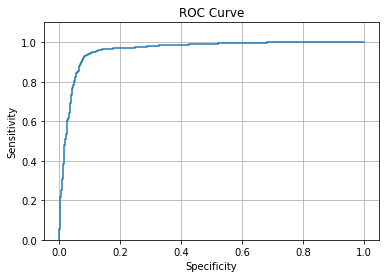

In [0]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_svd_train, y_train).predict(X_svd_test)
y_score = np.squeeze(gnb.predict_proba(X_svd_test))[:,1]
evaluation_parameters(y_test,y_pred)
plot_roc(y_test,y_score)

In [0]:
#Pipeline Implementation
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline

pipeline = Pipeline([('count_vectorization',CountVectorizer(min_df=3)),\
                      ('tfidf',TfidfTransformer()),('dim_red',TruncatedSVD()),('classifier',SVC())])
param_grid = [
{

    'count_vectorization': [CountVectorizer()],
    'count_vectorization__min_df':[3,5],
    'count_vectorization__tokenizer':[no_num_tokenizer,no_num_tokenizer_no_lemmatization],
    'dim_red': [TruncatedSVD(),NMF()],
    'dim_red__n_components': [50],
    'classifier': [SVC()],
    'classifier__C': [100]
}, 
{

    'count_vectorization': [CountVectorizer()],
    'count_vectorization__min_df':[3,5],
    'count_vectorization__tokenizer':[no_num_tokenizer,no_num_tokenizer_no_lemmatization],
    'dim_red': [TruncatedSVD(),NMF()],
    'dim_red__n_components': [50],
    'classifier': [LogisticRegression()],
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l2','l1'], 
    'classifier__C': [100] 
},
{

    'count_vectorization': [CountVectorizer()],
    'count_vectorization__min_df':[3,5],
    'count_vectorization__tokenizer':[no_num_tokenizer,no_num_tokenizer_no_lemmatization],
    'dim_red': [TruncatedSVD(),NMF()],
    'dim_red__n_components': [50],
    'classifier': [GaussianNB()]
} 
]

pipelinemodel = GridSearchCV(pipeline,cv =5,param_grid = param_grid,scoring='accuracy')
pipelinemodel.fit(train_dataset.data,y_train)
print(pipelinemodel.best_params_)

{'classifier': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'count_vectorization': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function no_num_tokenizer_no_lemmatization at 0x7f960b0a39d8>,
                vocabulary=None), 'count_vectorization__min_df': 3, 'count_vectorization_

In [0]:
#MULTI CLASS CLASSIFICATION SVM ONE VS Rest
multi_class_categories= ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

train_dataset,test_dataset = load_dataset(multi_class_categories,remove_header_flag=False)
X_train,X_test = count_vectorization(train_dataset,test_dataset,minimum_df=3,lemmatization_flag=True)
X_train_tfidf,X_test_tfidf = feature_extraction(X_train,X_test_tfidf)
W_train,W_test = NMF_reduction(X_train_tfidf,X_test_tfidf)
X_svd_train,X_svd_test = LSI_reduction(X_train_tfidf,X_test_tfidf)

multi_class_svm = SVC(decision_function_shape='ovr',C=100.0)
multi_class_svm.fit(X_svd_train, train_dataset.target)
y_pred = multi_class_svm.predict(X_svd_test)
confusion_matrix(test_dataset.target,y_pred)
print(classification_report(test_dataset.target, y_pred, target_names=multi_class_categories))

In [0]:
#MULTI CLASS CLASSIFICATION SVM ONE VS ONE

multi_class_svm = SVC(decision_function_shape='ovo',C=100.0)
multi_class_svm.fit(X_svd_train, train_dataset.target)
y_pred = multi_class_svm.predict(X_svd_test)
confusion_matrix(test_dataset.target,y_pred)
print(classification_report(test_dataset.target, y_pred, target_names=multi_class_categories))

In [0]:
#MULTI CLASS CLASSIFICATION Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_svd_train, train_dataset.target).predict(X_svd_test)
confusion_matrix(test_dataset.target,y_pred)
print(classification_report(test_dataset.target, y_pred, target_names=multi_class_categories))

